In [1]:
import sys

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import librosa
import librosa.display
import IPython.display as display

sys.path.append('../src')
import const
from metrics import row_wise_micro_averaged_f1_score, micro_f1_similarity

pd.options.display.max_rows=120

In [2]:
def fill_dropped(dropped_array, drop_idx):
    filled_array = np.zeros(
        (len(dropped_array) + len(drop_idx), dropped_array.shape[1])
    )
    idx_array = np.arange(len(filled_array))
    use_idx = np.delete(idx_array, drop_idx)
    filled_array[use_idx, :] = dropped_array
    return filled_array

In [3]:
def extract_label(preds, th=0.5):
    events = preds >= th
    nocall_col = np.zeros((len(preds), 1)).astype(bool)
    nocall_col[events.sum(1) == 0] = True
    events = np.concatenate([events, nocall_col], axis=1)
    
    predict_labels = []
    for i in range(len(events)):
        event = events[i, :]
        labels = np.argwhere(event).reshape(-1).tolist()
        
        row_labels = []
        for label in labels:
            row_labels.append(const.INV_BIRD_CODE[label])
        predict_labels.append(" ".join(row_labels))

    return predict_labels

In [152]:
def plot_oof(idx):
    plt.figure(figsize=(16, 6))
    plt.subplot(2, 1, 1)
    plt.plot(oof[idx, :])
    
    top5_bc = np.argsort(oof[idx, :])[-5:]
    
    for bc in range(len(oof[idx, :])):
        if bc in top5_bc:
            plt.text(bc, oof[idx, bc] - oof[idx, :].max() * 0.05, s=const.INV_BIRD_CODE[bc])
    plt.ylim([0, 1.0])
            
    plt.subplot(2, 1, 2)
    plt.plot(post_oof[idx, :])
    for bc in range(len(post_oof[idx, :])):
        if bc in top5_bc:
            plt.text(bc, post_oof[idx, bc] - post_oof[idx, :].max() * 0.05, s=const.INV_BIRD_CODE[bc])
    plt.ylim([0, 1.0])

In [5]:
valid_df = pd.read_csv('../data/input/train_soundscape_labels.csv')
use_idx = valid_df[~valid_df["audio_id"].isin([7019, 7954, 14473])].index
drop_idx = valid_df[valid_df["audio_id"].isin([7019, 7954, 14473])].index
valid_df = valid_df.iloc[use_idx].reset_index(drop=True)

val_y_labels = valid_df["birds"].tolist()

In [6]:
# oof4 = np.load("../logs/exp_004_20210409202215_0.701/oof.npy")
# oof10 = np.load("../logs/exp_010_20210412203406_0.684/oof.npy")
# oof11 = np.load("../logs/exp_011_20210413092718_0.710/oof.npy")
# oof12 = np.load("../logs/exp_012_20210413202510_0.700/oof.npy")
# oof20 = np.load("../logs/exp_020_20210420203023_0.698/oof.npy")
# oof21 = np.load("../logs/exp_021_20210421105635_0.701/oof.npy")
# oof22 = np.load("../logs/exp_022_20210421213519_0.712/oof.npy")
# oof23 = np.load("../logs/exp_023_20210422072541_0.696/oof.npy")
# oof24 = np.load("../logs/exp_024_20210422215622_0.684/oof.npy")
# oof25 = np.load("../logs/exp_025_20210423142123_0.684/oof.npy")
# oof28 = np.load("../logs/exp_028_20210425165254_0.671/oof.npy")
# oof28 = np.load("../logs/exp_028_20210425165254_0.671/oof.npy")
# # oof29 = np.load("../logs/exp_029_20210425212038_0.675/oof.npy")
# # oof32 = np.load("../logs/exp_032_20210426185313_0.684/oof.npy")
# # oof33 = np.load("../logs/exp_033_20210426230524_0.701/oof.npy")
# # oof34 = np.load("../logs/exp_034_20210427025324_0.686/oof.npy")
# # oof35 = np.load("../logs/exp_035_20210427085305_0.690/oof.npy")

# oof40 = np.load("../logs/exp_040_20210428095746_0.696/oof.npy")
# oof41 = np.load("../logs/exp_041_20210428173715_0.689/oof.npy")
# oof42 = np.load("../logs/exp_042_20210429120526_0.692/oof.npy")
# oof43 = np.load("../logs/exp_043_20210429195623_0.697/oof.npy")
# oof44 = np.load("../logs/exp_044_20210429235301_0.707/oof.npy")
# oof45 = np.load("../logs/exp_045_20210430131333_0.695/oof.npy")
# oof50 = np.load("../logs/exp_050_20210502230529_0.679/oof.npy")
# oof51 = np.load("../logs/exp_051_20210503030848_0.694/oof.npy")
# oof52 = np.load("../logs/exp_052_20210503093904_0.692/oof.npy")

# oof54 = np.load("../logs/exp_054_20210503234704_0.685/oof.npy")
# oof55 = np.load("../logs/exp_055_20210504024705_0.693/oof.npy")
# oof55 = oof54 * 0.5 + oof55 * 0.5

# oof56 = np.load("../logs/exp_056_20210504114210_0.697/oof.npy")
# oof57 = np.load("../logs/exp_057_20210504153605_0.690/oof.npy")
# oof58 = np.load("../logs/exp_058_20210504202445_0.679/oof.npy")
# oof60 = np.load("../logs/exp_060_20210505181921_0.706/oof.npy")
# oof61 = np.load("../logs/exp_061_20210505232548_0.656/oof.npy")
# oof62 = np.load("../logs/exp_062_20210506032156_0.648/oof.npy")
# oof65 = np.load("../logs/exp_065_20210507102634_0.640/oof.npy")
# oof65 = fill_dropped(oof65, drop_idx)
# oof66 = np.load("../logs/exp_066_20210507141914_0.637/oof.npy")
# oof66 = fill_dropped(oof66, drop_idx)
# oof67 = np.load("../logs/exp_067_20210507230447_0.629/oof.npy")
# oof68 = np.load("../logs/exp_068_20210508025654_0.620/oof.npy")
# oof74 = np.load("../logs/exp_074_20210509223155_3.172/oof.npy")
# oof74 = fill_dropped(oof74, drop_idx)
# oof76 = np.load("../logs/exp_076_20210511000515_0.629/oof.npy")
# oof76 = fill_dropped(oof76, drop_idx)
# oof77 = np.load("../logs/exp_077_20210511035734_0.629/oof.npy")
# oof77 = fill_dropped(oof77, drop_idx)
# oof78 = np.load("../logs/exp_078_20210511074917_0.633/oof.npy")
# oof78 = fill_dropped(oof78, drop_idx)
# oof81 = np.load("../logs/exp_081_20210511225340_0.636/oof.npy")
# oof81 = fill_dropped(oof81, drop_idx)
# oof82 = np.load("../logs/exp_082_20210512024531_0.625/oof.npy")
# oof82 = fill_dropped(oof82, drop_idx)
# oof86 = np.load("../logs/exp_086_20210512183544_0.632/oof.npy")
# oof86 = fill_dropped(oof86, drop_idx)
# oof87 = np.load("../logs/exp_087_20210512231955_0.619/oof.npy")
# oof87 = fill_dropped(oof87, drop_idx)
# oof88 = np.load("../logs/exp_088_20210513031332_0.628/oof.npy")
# oof88 = fill_dropped(oof88, drop_idx)
# oof89 = np.load("../logs/exp_089_20210513093810_0.627/oof.npy")
# oof89 = fill_dropped(oof89, drop_idx)
# oof91 = np.load("../logs/exp_091_20210514120344_0.639/oof.npy")
# oof91 = fill_dropped(oof91, drop_idx)
# oof92 = np.load("../logs/exp_092_20210514160253_0.650/oof.npy")
# oof92 = fill_dropped(oof92, drop_idx)
# oof93 = np.load("../logs/exp_093_20210514195743_0.630/oof.npy")
# oof93 = fill_dropped(oof93, drop_idx)
# oof95 = np.load("../logs/exp_095_20210515002049_0.633/oof.npy")
# oof95 = fill_dropped(oof95, drop_idx)
# oof96 = np.load("../logs/exp_096_20210515042121_0.636/oof.npy")
# oof96 = fill_dropped(oof96, drop_idx)
# oof97 = np.load("../logs/exp_097_20210515081329_0.653/oof.npy")
# oof97 = fill_dropped(oof97, drop_idx)
# oof100 = np.load("../logs/exp_100_20210516094037_0.620/oof.npy")
# oof100 = fill_dropped(oof100, drop_idx)
# oof101 = np.load("../logs/exp_101_20210516134723_0.650/oof.npy")
# oof101 = fill_dropped(oof101, drop_idx)
# oof102 = np.load("../logs/exp_102_20210516214845_0.620/oof.npy")
# oof102 = fill_dropped(oof102, drop_idx)
# oof106 = np.load("../logs/exp_106_20210519022652_0.601/oof.npy")
# oof106 = fill_dropped(oof106, drop_idx)
oof112 = np.load("../logs/exp_112_20210520045116_0.638/oof.npy")
oof112 = fill_dropped(oof112, drop_idx)
oof114 = np.load("../logs/exp_114_20210520192947_0.650/oof.npy")
oof114 = fill_dropped(oof114, drop_idx)
oof115 = np.load("../logs/exp_115_20210520232446_0.631/oof.npy")
oof115 = fill_dropped(oof115, drop_idx)
oof116 = np.load("../logs/exp_116_20210521031557_0.641/oof.npy")
oof116 = fill_dropped(oof116, drop_idx)
oof117 = np.load("../logs/exp_117_20210521070917_0.640/oof.npy")
oof117 = fill_dropped(oof117, drop_idx)
oof118 = np.load("../logs/exp_118_20210521110036_0.653/oof.npy")
oof118 = fill_dropped(oof118, drop_idx)
oof121 = np.load("../logs/exp_121_20210521215739_0.637/oof.npy")
oof121 = fill_dropped(oof121, drop_idx)

oof129 = np.load("../logs/exp_129_20210523145254_0.641/oof.npy")
oof129 = fill_dropped(oof129, drop_idx)
oof131 = np.load("../logs/exp_131_20210524005536_0.641/oof.npy")
oof131 = fill_dropped(oof131, drop_idx)
oof132 = np.load("../logs/exp_132_20210524061303_0.623/oof.npy")
oof132 = fill_dropped(oof132, drop_idx)
oof133 = np.load("../logs/exp_133_20210524105841_0.630/oof.npy")
oof133 = fill_dropped(oof133, drop_idx)
oof134 = np.load("../logs/exp_134_20210524160839_0.636/oof.npy")
oof134 = fill_dropped(oof134, drop_idx)
oof135 = np.load("../logs/exp_135_20210524214504_0.649/oof.npy")
oof135 = fill_dropped(oof135, drop_idx)
oof136 = np.load("../logs/exp_136_20210525032138_0.623/oof.npy")
oof136 = fill_dropped(oof136, drop_idx)
oof137 = np.load("../logs/exp_137_20210525173848_0.631/oof.npy")
oof137 = fill_dropped(oof137, drop_idx)
oof139 = np.load("../logs/exp_139_20210526031224_0.661/oof.npy")
oof139 = fill_dropped(oof139, drop_idx)
oof140 = np.load("../logs/exp_140_20210525120925_0.577/oof.npy")
oof140 = fill_dropped(oof140, drop_idx)
oof142 = np.load("../logs/exp_142_20210526125837_0.651/oof.npy")
oof142 = fill_dropped(oof142, drop_idx)

# nocall classification
oof59 = np.load("../logs/exp_059_20210505100513_0.666/oof.npy")
oof70 = np.load("../logs/exp_070_20210508193023_0.882/oof.npy")
oof79 = np.load("../logs/exp_079_20210511132329_0.874/oof.npy")
oof83 = np.load("../logs/exp_083_20210512081958_0.827/oof.npy")
oof99 = np.load("../logs/exp_099_20210515202257_0.859/oof.npy")

In [7]:
oof_list = [
    oof112,
    oof114,
    oof115,
    oof116,
    oof117,
    oof118,

    oof129,
    oof131,
    oof132,
#     oof137,
    oof139,
]

concat_oof = []
for oof_ in oof_list:
    concat_oof.append(oof_[np.newaxis, :, :])
concat_oof = np.concatenate(concat_oof)

In [8]:
oof = np.mean(concat_oof, axis=0)[use_idx, :]
oof_labels = extract_label(oof, th=0.26)

In [9]:
score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
score

0.7035784313725466

In [10]:
def post_process_v2_plus(preds, df, c=2, q=0.99, w=1.5):
    post_preds = preds.copy()
    
    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        
        audio_preds = preds[idxs, :]
        audio_preds_mean = np.mean(audio_preds, axis=0)
        audio_preds_mean_ = audio_preds_mean / audio_preds_mean.max()
        quantile = np.quantile(audio_preds_mean_, q)

        for bc in np.argsort(audio_preds_mean_)[::-1]:
            v = audio_preds_mean_[bc]
            if v >= (quantile * c):
                for idx in idxs:
                    if np.argmax(post_preds[idx, :]) == bc:
                        post_preds[idx, bc] *= w
            else:
                break

    return post_preds


def shift(df, pred_labels, freq):
    shift_labels = [None] * len(df)

    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        audio_shift_labels = np.roll(pred_labels[idxs[0]: idxs[-1] + 1], freq)
        
        if freq > 0:
            audio_shift_labels[:freq] = "None"
        elif freq < 0:
            audio_shift_labels[freq:] = "None"
            
        shift_labels[idxs[0]: idxs[-1] + 1] = audio_shift_labels

    return shift_labels


def intersect(labels_list1, labels_list2):
    intersect_list = []
    for idx in range(len(labels_list1)):
        lables1 = labels_list1[idx].split(" ")
        lables2 = labels_list2[idx].split(" ")
        
        intersect = np.intersect1d(lables1, lables2)
        if len(intersect) == 0:
            intersect = ["nocall"]
        intersect_list.append(" ".join(list(intersect)))
        
    return intersect_list


def add_label(labels_list1, labels_list2):
    added_labels_list = []
    for labels1, labels2 in zip(labels_list1, labels_list2):

        if labels1 == "nocall":
            if labels2 == "nocall":
                added_labels_list.append("nocall")
            else:
                added_labels_list.append(labels2)
        
        else:
            if labels2 == "nocall":
                added_labels_list.append(labels1)
            else:
                added_labels = list(set((labels1 + " " + labels2).split(" ")))
                added_labels_list.append(" ".join(added_labels))
    
    return added_labels_list


def post_process_v10(preds, pred_labels, df, window_size=1, c=2.0):
    first_labels = []
    for idx in df.index:
        row_prob = preds[idx, :]
        second_prob = np.sort(row_prob)[-2]

        first_label_bc = np.argmax(row_prob)
        v = row_prob[first_label_bc]
        if v >= (second_prob * c):
            first_labels.append(const.INV_BIRD_CODE[first_label_bc])
        else:
            first_labels.append("nocall")

    final_labels_list = pred_labels.copy()
    for w in range(window_size):
        for freq in [w + 1, -(w + 1)]:
            shift_labels = shift(df, pred_labels, freq)
            shift_intersect_labels = intersect(first_labels, shift_labels)
            final_labels_list = add_label(final_labels_list, shift_intersect_labels)
        
    return final_labels_list

In [11]:
post_oof = post_process_v2_plus(oof, valid_df, c=2.5, q=0.99, w=2.0)
oof_labels_ = extract_label(post_oof, th=0.65)
post_oof_labels = post_process_v10(post_oof, oof_labels_, valid_df, window_size=5, c=2.0)

In [12]:
score = row_wise_micro_averaged_f1_score(val_y_labels, post_oof_labels)
score

0.7472385620915006

In [13]:
valid_df["oof_birds"] = oof_labels
valid_df["post_oof_birds"] = post_oof_labels

oof_argsort_array = np.argsort(oof, axis=1)[:, ::-1]

valid_df["first_label"] = oof_argsort_array[:, 0]
valid_df["second_label"] = oof_argsort_array[:, 1]
valid_df["third_label"] = oof_argsort_array[:, 2]

valid_df["first_label"] = valid_df["first_label"].apply(lambda x: const.INV_BIRD_CODE[x])
valid_df["second_label"] = valid_df["second_label"].apply(lambda x: const.INV_BIRD_CODE[x])
valid_df["third_label"] = valid_df["third_label"].apply(lambda x: const.INV_BIRD_CODE[x])

In [14]:
valid_df["nocall_birds"] = 0
valid_df.loc[valid_df[valid_df["birds"] == "nocall"].index, "nocall_birds"] = 1

valid_df["nocall_oof_birds"] = 0
valid_df.loc[valid_df[valid_df["oof_birds"] == "nocall"].index, "nocall_oof_birds"] = 1

In [15]:
f1_array = np.zeros(len(valid_df))
for idx in valid_df.index:
    b = valid_df.loc[idx, "birds"]
    pb = valid_df.loc[idx, "post_oof_birds"]
    f1_array[idx] = micro_f1_similarity(b, pb)

valid_df["f1"] = f1_array
valid_df.head()

row_id site  audio_id  seconds    birds oof_birds post_oof_birds  \
0   11254_COR_5  COR     11254        5  rubwre1   wbwwre1        wbwwre1   
1  11254_COR_10  COR     11254       10   nocall   wbwwre1        wbwwre1   
2  11254_COR_15  COR     11254       15  rubwre1   wbwwre1        wbwwre1   
3  11254_COR_20  COR     11254       20   nocall    nocall         nocall   
4  11254_COR_25  COR     11254       25  rubwre1   rubwre1        rubwre1   

  first_label second_label third_label  nocall_birds  nocall_oof_birds   f1  
0     wbwwre1      orbeup1     rubwre1             0                 0  0.0  
1     wbwwre1      rubwre1     orbeup1             1                 0  0.0  
2     wbwwre1      rubwre1     orbeup1             0                 0  0.0  
3      meapar      creoro1      fepowl             1                 1  1.0  
4     rubwre1      baywre1     wbwwre1             0                 0  1.0

In [16]:
valid_df["diff"] = (valid_df["birds"].apply(lambda x: 1 if x == "nocall" else 0) - 
                                 valid_df["oof_birds"].apply(lambda x: 1 if x == "nocall" else 0))
valid_df["diff_pattern"] = valid_df["diff"].map({-1: "bird -> nocall", 0: "birdX -> birdY", 1: "nocall -> bird"})
valid_df["birdcall_p"] = oof79.reshape(-1)

In [17]:
valid_df["diff_pattern"].value_counts()

birdX -> birdY    1517
bird -> nocall     444
nocall -> bird      79
Name: diff_pattern, dtype: int64

何かしらの鳥の鳴き声が聞こえているのに `nocall`と予測しているパターンが多い

In [18]:
valid_df[valid_df["f1"] < 1]

row_id site  audio_id  seconds    birds oof_birds post_oof_birds  \
0       11254_COR_5  COR     11254        5  rubwre1   wbwwre1        wbwwre1   
1      11254_COR_10  COR     11254       10   nocall   wbwwre1        wbwwre1   
2      11254_COR_15  COR     11254       15  rubwre1   wbwwre1        wbwwre1   
6      11254_COR_35  COR     11254       35   nocall   wbwwre1        wbwwre1   
38    11254_COR_195  COR     11254      195   nocall    yebfly         yebfly   
...             ...  ...       ...      ...      ...       ...            ...   
2031  54955_SSW_560  SSW     54955      560   grycat    nocall         nocall   
2033  54955_SSW_570  SSW     54955      570   grycat    nocall         nocall   
2034  54955_SSW_575  SSW     54955      575   chswar    nocall         nocall   
2036  54955_SSW_585  SSW     54955      585   grycat    nocall         nocall   
2037  54955_SSW_590  SSW     54955      590   grycat    nocall         nocall   

     first_label second_label third_label  nocall_birds  nocall_oof_birds  \
0        wbwwre1      orbeup1     rubwre1             0                 0   
1        wbwwre1      rubwre1     orbeup1             1                 0   
2        wbwwre1      rubwre1     orbeup1             0                 0   
6        wbwwre1      rubwre1     orbeup1             1                 0   
38        yebfly       acafly      haiwoo             1                 0   
...          ...          ...         ...           ...               ...   
2031      gwfgoo       grhowl      grycat             0                 1   
2033      grycat       blujay      buggna             0                 1   
2034      chswar       canwar      wlswar             0                 1   
2036      amered       warvir     mallar3             0                 1   
2037      grycat       grhowl      warvir             0                 1   

       f1  diff    diff_pattern  birdcall_p  
0     0.0     0  birdX -> birdY    1.000000  
1     0.0     1  nocall -> bird    1.000000  
2     0.0     0  birdX -> birdY    1.000000  
6     0.0     1  nocall -> bird    0.999982  
38    0.0     1  nocall -> bird    0.999249  
...   ...   ...             ...         ...  
2031  0.0    -1  bird -> nocall    0.617323  
2033  0.0    -1  bird -> nocall    0.091170  
2034  0.0    -1  bird -> nocall    0.986755  
2036  0.0    -1  bird -> nocall    0.419688  
2037  0.0    -1  bird -> nocall    0.129231  

[597 rows x 16 columns]

In [19]:
gp = valid_df.groupby("audio_id")

corr_array = np.zeros(len(oof))
for audio_id, audio_df in gp:
    idxs = audio_df.index.values
    
    for i, idx in enumerate(idxs):
        if i == 0:
            pass
        else:
            corr = np.corrcoef(oof[idx - 1, :], oof[idx, :])[0, 1]
            corr_array[idx] = corr
            
valid_df["corr"] = corr_array

In [20]:
# usecols = ["row_id", "seconds", "birds", "oof_birds", "post_oof_birds", "first_label", "second_label", "third_label", "birdcall_p"]
usecols = ["row_id", "seconds", "birds", "post_oof_birds", "first_label", "second_label", "birdcall_p", "corr", "f1"]

In [21]:
for audio_id, audio_df in gp:
    idxs = audio_df.index.values
    score = row_wise_micro_averaged_f1_score( valid_df.loc[idxs, "birds"].values, valid_df.loc[idxs, "oof_birds"])

    print(f"audio_id: {audio_id}\n score: {score:.4f}   nocall_mean: {1 - audio_df['birdcall_p'].mean():.4f}")
    print("-" * 50)
    print(audio_df['birds'].value_counts())
    print("\n")
    print(audio_df['oof_birds'].value_counts())
    print("\n")
    print(audio_df[valid_df["f1"] == 0]["diff_pattern"].value_counts())
    print("\n" * 2)

audio_id: 2782
 score: 0.3247   nocall_mean: 0.0036
--------------------------------------------------
eawpew reevir1                  37
reevir1                         23
bkcchi eawpew reevir1           20
eawpew grycat reevir1           16
grycat reevir1                   9
bkcchi reevir1                   8
bkcchi eawpew grycat reevir1     3
bkcchi grycat reevir1            2
chswar eawpew reevir1            1
chswar eawpew grycat reevir1     1
Name: birds, dtype: int64


nocall            62
reevir1           29
grycat            17
eawpew             9
grycat obnthr1     2
obnthr1            1
Name: oof_birds, dtype: int64


bird -> nocall    38
birdX -> birdY     8
Name: diff_pattern, dtype: int64



audio_id: 7843
 score: 0.9667   nocall_mean: 0.7868
--------------------------------------------------
nocall    116
bkcchi      2
blujay      2
Name: birds, dtype: int64


nocall    120
Name: oof_birds, dtype: int64


bird -> nocall    4
Name: diff_pattern, dtype: int64



audio_id

<ipython-input-21-2feb01688c78>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(audio_df[valid_df["f1"] == 0]["diff_pattern"].value_counts())
<ipython-input-21-2feb01688c78>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(audio_df[valid_df["f1"] == 0]["diff_pattern"].value_counts())
<ipython-input-21-2feb01688c78>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(audio_df[valid_df["f1"] == 0]["diff_pattern"].value_counts())
<ipython-input-21-2feb01688c78>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(audio_df[valid_df["f1"] == 0]["diff_pattern"].value_counts())
<ipython-input-21-2feb01688c78>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(audio_df[valid_df["f1"] == 0]["diff_pattern"].value_counts())
<ipython-input-21-2feb01688c78>:11: UserWarning: Boolean Series key will be reindexed to m

## audio_id: 2782

In [22]:
idx = valid_df[valid_df["audio_id"] == 2782].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1"])

In [158]:
(df["oof_birds"] != df["post_oof_birds"]).sum()

7

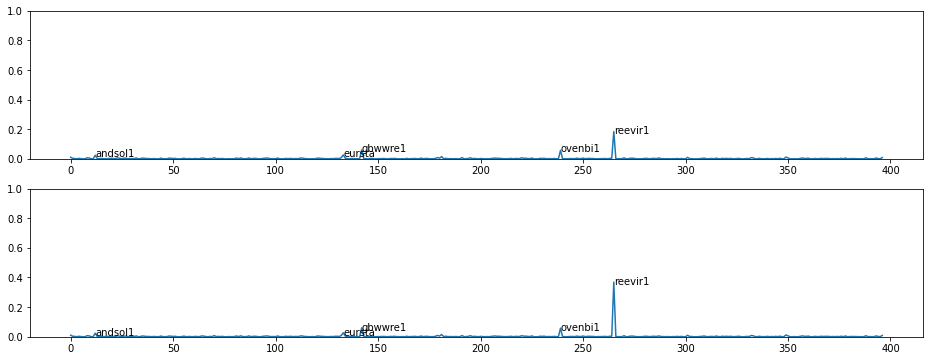

In [168]:
plot_oof(1065)

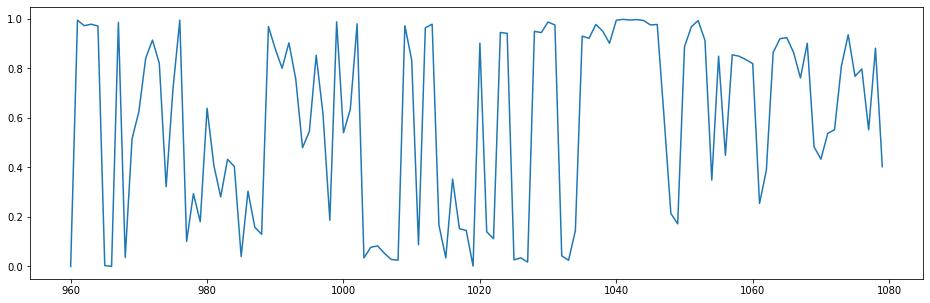

In [24]:
plt.figure(figsize=(16, 5))
plt.plot(df["corr"])

In [25]:
np.corrcoef(oof[1055, :], oof[1056, :])[0, 1]

0.4491657308142173

In [26]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["oof_birds"])

0.32472222222222225

In [27]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.5536111111111108

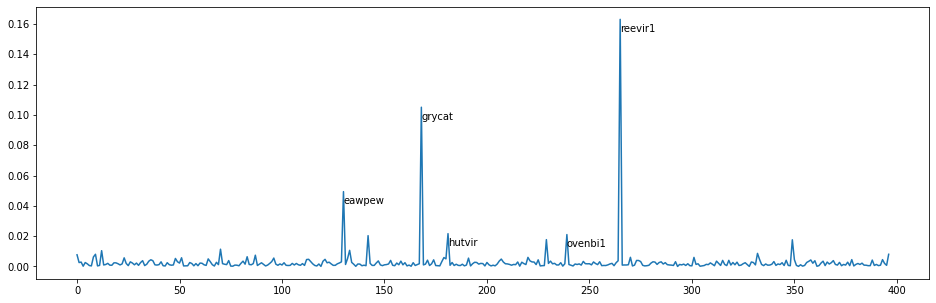

In [28]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [29]:
top5_birds

['eawpew', 'grycat', 'hutvir', 'ovenbi1', 'reevir1']

## audio_id: 7843

In [160]:
idx = valid_df[valid_df["audio_id"] == 7843].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1"])

In [161]:
(df["oof_birds"] != df["post_oof_birds"]).sum()

0

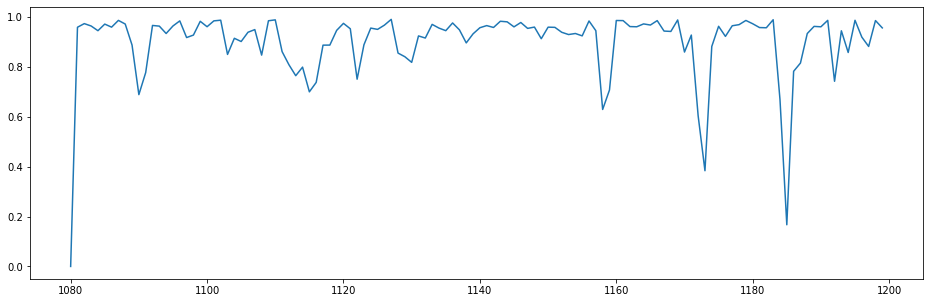

In [31]:
plt.figure(figsize=(16, 5))
plt.plot(df["corr"])

In [32]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["oof_birds"])

0.9666666666666657

In [33]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.016666666666666666

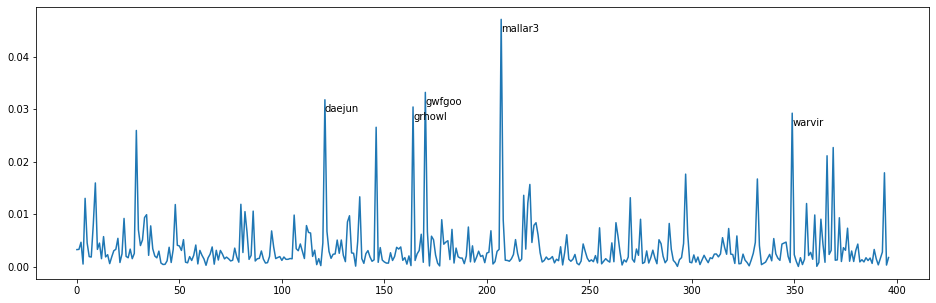

In [34]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [35]:
top5_birds

['daejun', 'grhowl', 'gwfgoo', 'mallar3', 'warvir']

In [36]:
np.argsort(oof112[1200: 1320, :].mean(0))[::-1][:3]

array([265, 168, 130])

In [37]:
np.argsort(oof112[1275, :])[::-1][:3]

array([265,  87, 239])

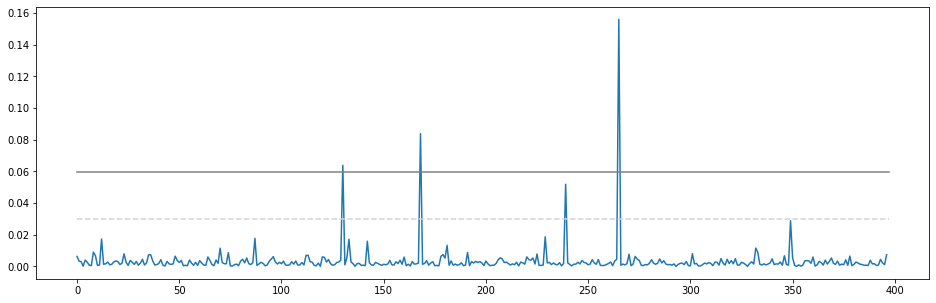

In [38]:
q = np.quantile(oof112[1200: 1320, :].mean(0), q=0.99)
q2 = q * 2

plt.figure(figsize=(16, 5))
plt.plot(oof112[1200: 1320, :].mean(0))
plt.plot([0, 397], [q, q], "--", c="lightgrey")
plt.plot([0, 397], [q2, q2], "-", c="gray")

(-0.05, 1.0)

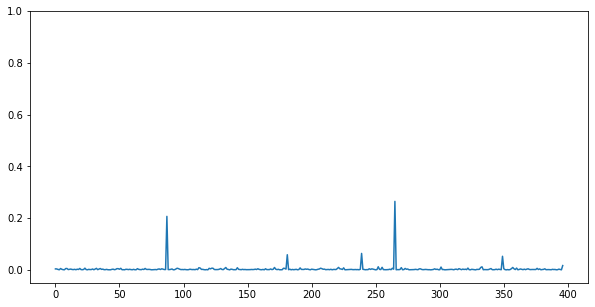

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(oof112[1275, :])
plt.ylim([-0.05, 1.0])

## audio_id: 10534

In [162]:
idx = valid_df[valid_df["audio_id"] == 10534].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1"])

In [163]:
(df["oof_birds"] != df["post_oof_birds"]).sum()

24

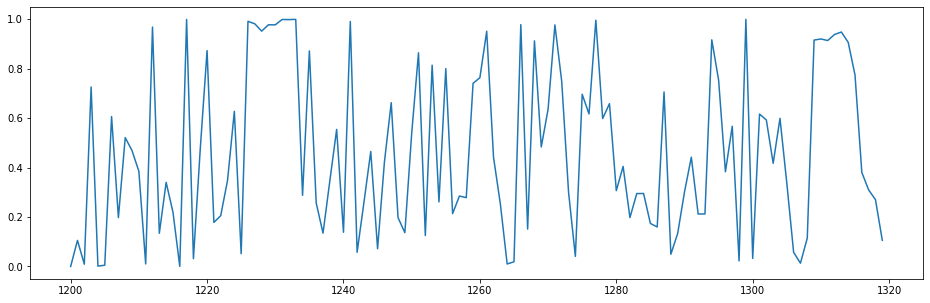

In [41]:
plt.figure(figsize=(16, 5))
plt.plot(df["corr"])

In [42]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["oof_birds"])

0.6861111111111111

In [43]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.3166666666666668

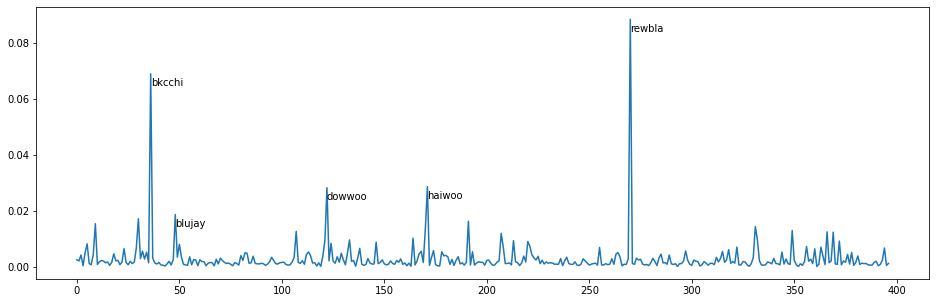

In [44]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [45]:
top5_birds

['bkcchi', 'blujay', 'dowwoo', 'haiwoo', 'rewbla']

## audio_id: 11254

In [164]:
idx = valid_df[valid_df["audio_id"] == 11254].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1"])

In [165]:
(df["oof_birds"] != df["post_oof_birds"]).sum()

6

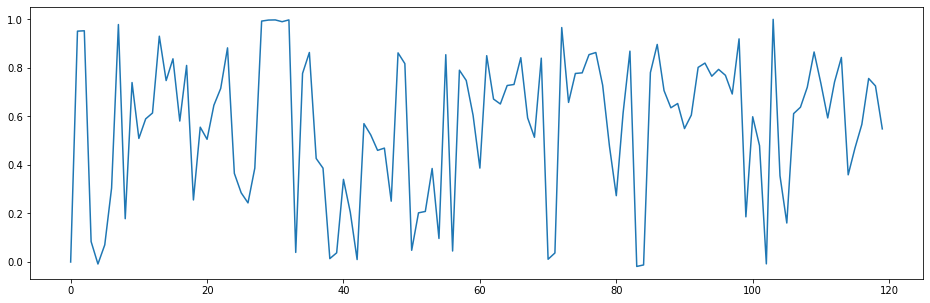

In [47]:
plt.figure(figsize=(16, 5))
plt.plot(df["corr"])

In [48]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["oof_birds"])

0.8833333333333326

In [49]:
len(df[df["birds"] == "nocall"])

105

In [50]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.08888888888888888

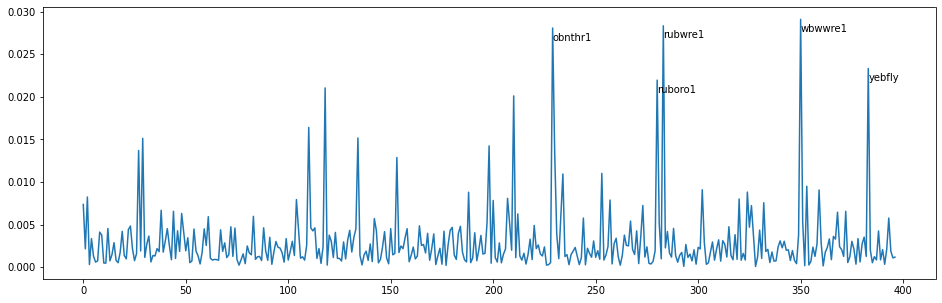

In [51]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [52]:
top5_birds

['obnthr1', 'ruboro1', 'rubwre1', 'wbwwre1', 'yebfly']

## audio_id: 18003

In [166]:
idx = valid_df[valid_df["audio_id"] == 18003].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1"])

In [167]:
(df["oof_birds"] != df["post_oof_birds"]).sum()

23

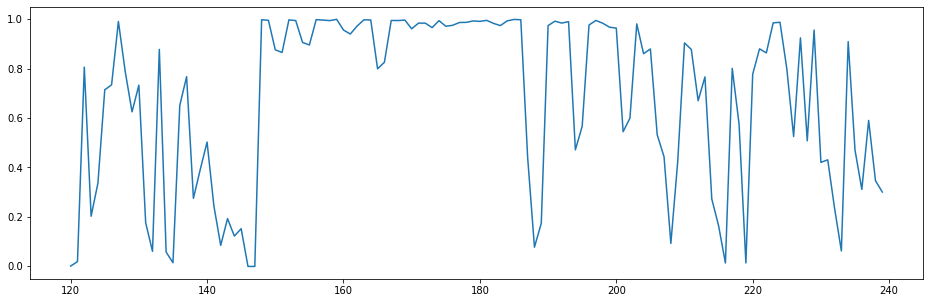

In [54]:
plt.figure(figsize=(16, 5))
plt.plot(df["corr"])

In [55]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["oof_birds"])

0.6361111111111112

In [56]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.6166666666666669

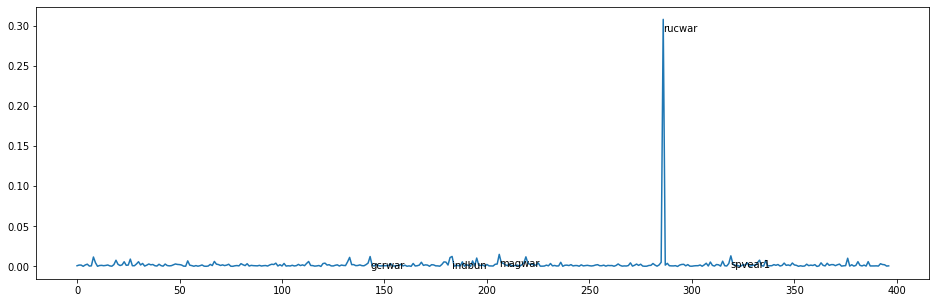

In [57]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [58]:
top5_birds

['gcrwar', 'indbun', 'magwar', 'rucwar', 'spvear1']

## audio_id: 20152

In [59]:
idx = valid_df[valid_df["audio_id"] == 20152].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1"])

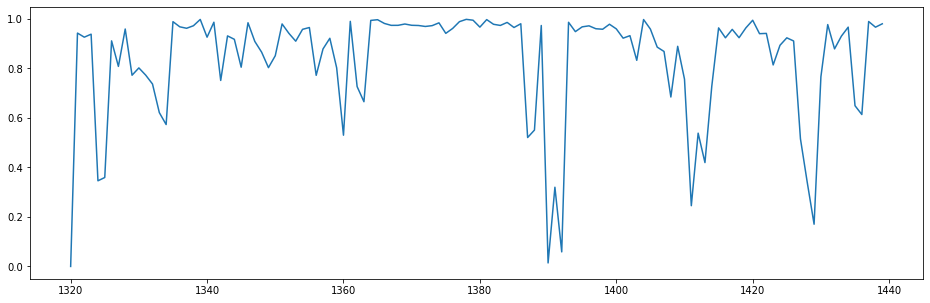

In [60]:
plt.figure(figsize=(16, 5))
plt.plot(df["corr"])

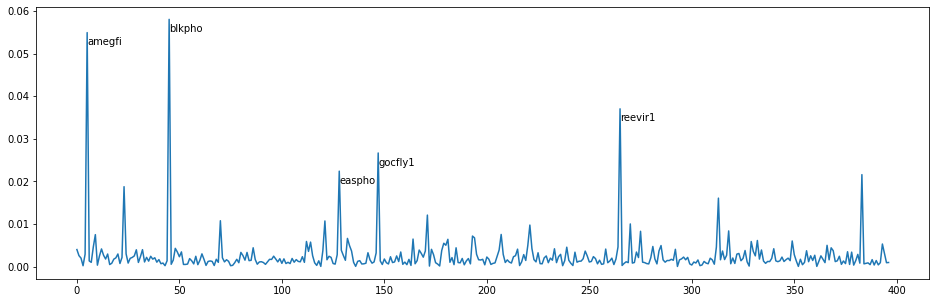

In [61]:
plot_oof(1412)

In [62]:
len(df[df["birds"] == "nocall"])

116

In [63]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["oof_birds"])

0.9333333333333325

In [64]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.016666666666666666

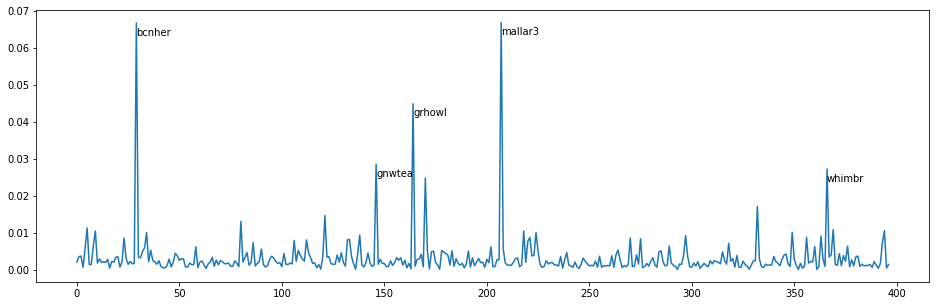

In [65]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [66]:
top5_birds

['bcnher', 'gnwtea', 'grhowl', 'mallar3', 'whimbr']

## audio_id: 21767

In [67]:
idx = valid_df[valid_df["audio_id"] == 21767].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1"])

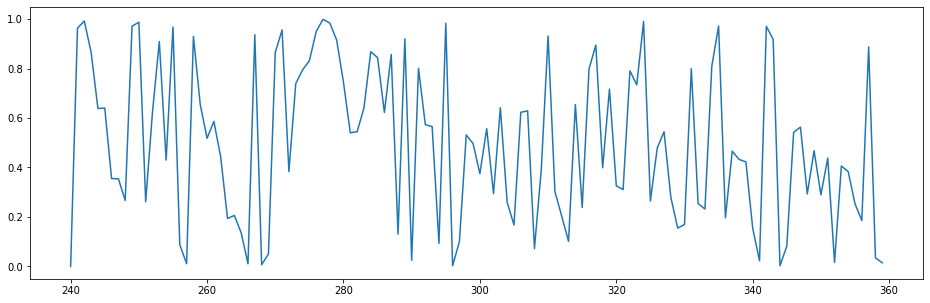

In [68]:
plt.figure(figsize=(16, 5))
plt.plot(df["corr"])

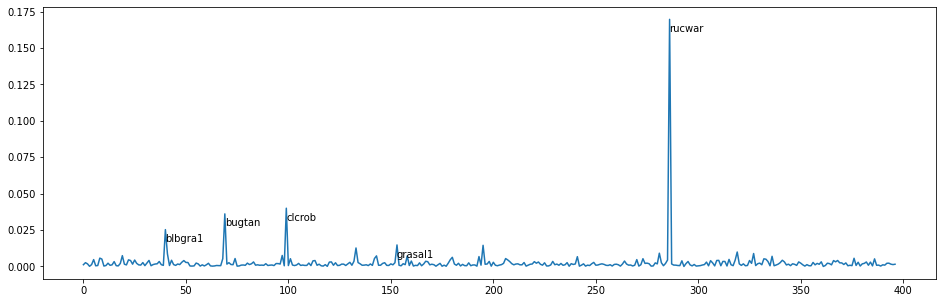

In [69]:
plot_oof(261)

In [70]:
len(df[df["birds"] == "nocall"])

22

In [71]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["oof_birds"])

0.3444444444444447

In [72]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.35972222222222244

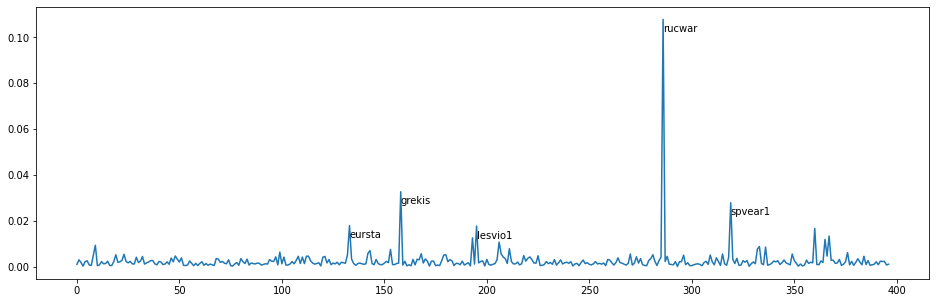

In [73]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [74]:
top5_birds

['eursta', 'grekis', 'lesvio1', 'rucwar', 'spvear1']

## audio_id: 26709

In [75]:
idx = valid_df[valid_df["audio_id"] == 26709].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1"])

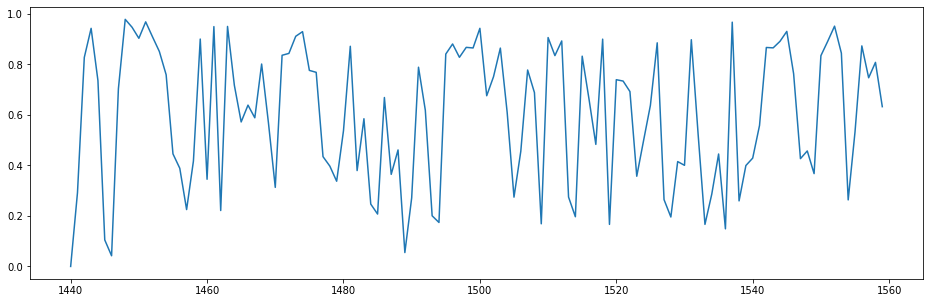

In [76]:
plt.figure(figsize=(16, 5))
plt.plot(df["corr"])

In [77]:
np.max(oof[1514, :])

0.13335066481959074

In [78]:
len(df[df["birds"] == "nocall"])

62

In [79]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.06388888888888888

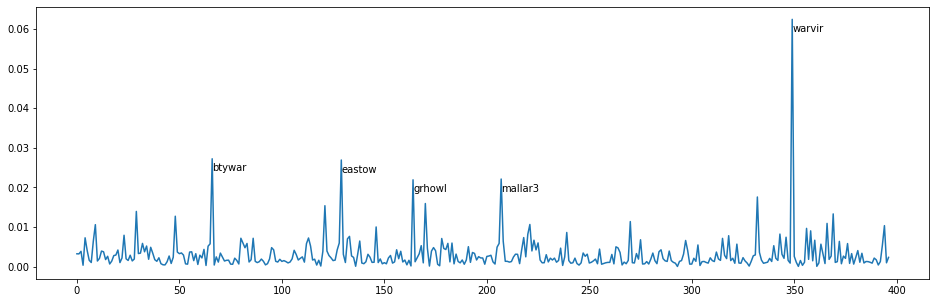

In [80]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [81]:
top5_birds

['btywar', 'eastow', 'grhowl', 'mallar3', 'warvir']

## audio_id: 26746

In [82]:
idx = valid_df[valid_df["audio_id"] == 26746].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1"])

In [83]:
np.max(oof[1514, :])

0.13335066481959074

In [84]:
len(df[df["birds"] == "nocall"])

71

In [85]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.175

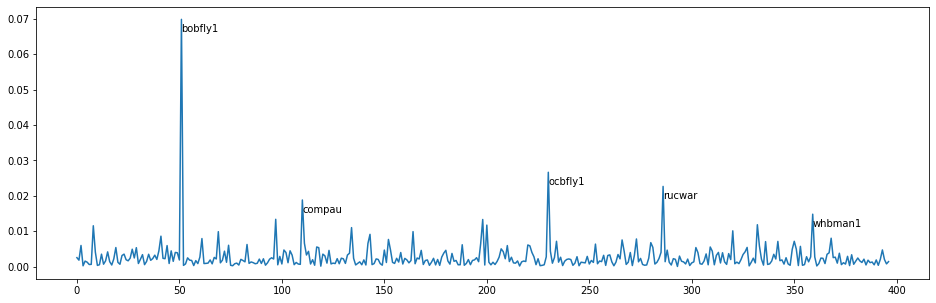

In [86]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [87]:
top5_birds

['bobfly1', 'compau', 'ocbfly1', 'rucwar', 'whbman1']

## audio_id: 28933

In [88]:
idx = valid_df[valid_df["audio_id"] == 28933].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1"])

In [89]:
np.max(oof[1514, :])

0.13335066481959074

In [90]:
len(df[df["birds"] == "nocall"])

18

In [91]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.49305555555555547

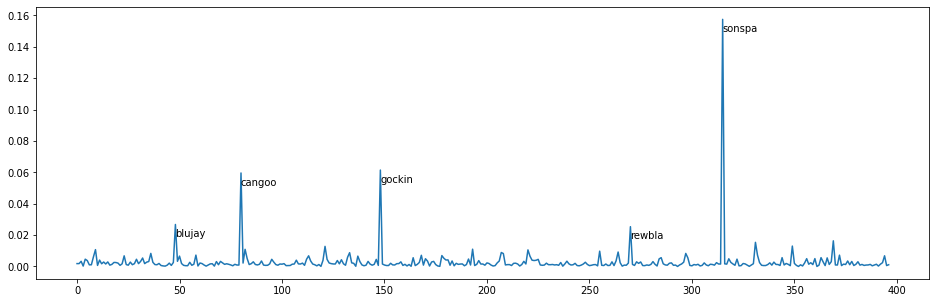

In [92]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [93]:
top5_birds

['blujay', 'cangoo', 'gockin', 'rewbla', 'sonspa']

## audio_id: 31928

In [94]:
idx = valid_df[valid_df["audio_id"] == 31928].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1"])

In [95]:
np.max(oof[1514, :])

0.13335066481959074

In [96]:
len(df[df["birds"] == "nocall"])

120

In [97]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.0

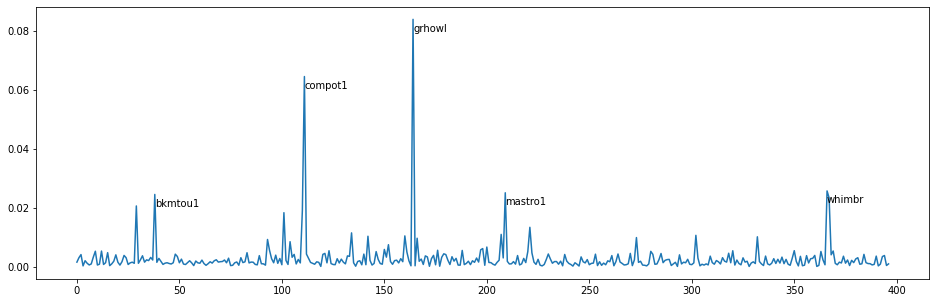

In [98]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [99]:
top5_birds

['bkmtou1', 'compot1', 'grhowl', 'mastro1', 'whimbr']

## audio_id: 42907

In [100]:
idx = valid_df[valid_df["audio_id"] == 42907].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1"])

In [101]:
np.max(oof[1514, :])

0.13335066481959074

In [102]:
len(df[df["birds"] == "nocall"])

75

In [103]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.35000000000000026

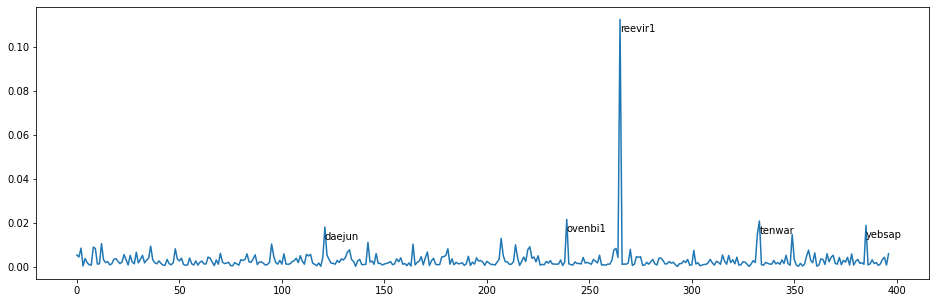

In [104]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [105]:
top5_birds

['daejun', 'ovenbi1', 'reevir1', 'tenwar', 'yebsap']

## audio_id: 44957

In [106]:
idx = valid_df[valid_df["audio_id"] == 44957].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1"])

In [107]:
np.max(oof[1514, :])

0.13335066481959074

In [108]:
len(df[df["birds"] == "nocall"])

49

In [109]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.45277777777777845

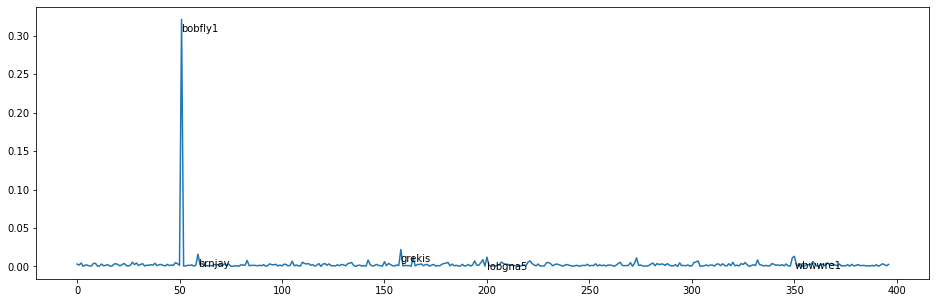

In [110]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [111]:
top5_birds

['bobfly1', 'brnjay', 'grekis', 'lobgna5', 'wbwwre1']

## audio_id: 50878

In [112]:
idx = valid_df[valid_df["audio_id"] == 50878].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1"])

In [113]:
np.max(oof[1514, :])

0.13335066481959074

In [114]:
len(df[df["birds"] == "nocall"])

115

In [115]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.041666666666666664

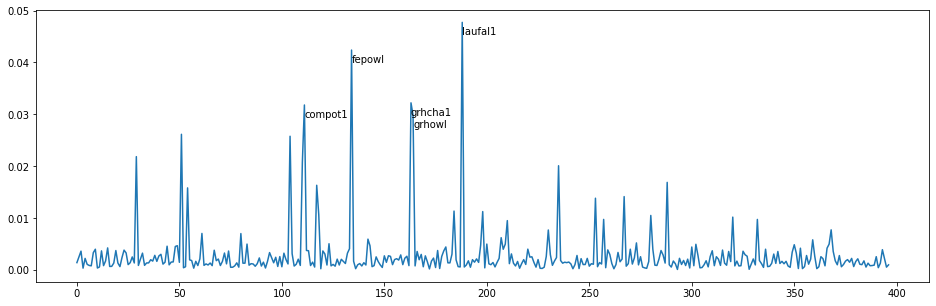

In [116]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [117]:
top5_birds

['compot1', 'fepowl', 'grhcha1', 'grhowl', 'laufal1']

## audio_id: 51010

In [118]:
idx = valid_df[valid_df["audio_id"] == 51010].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1"])

In [119]:
np.max(oof[1514, :])

0.13335066481959074

In [120]:
len(df[df["birds"] == "nocall"])

28

In [121]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.4055555555555556

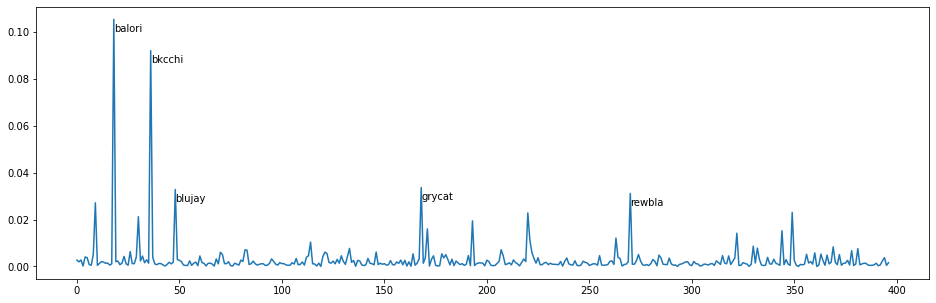

In [122]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [123]:
top5_birds

['balori', 'bkcchi', 'blujay', 'grycat', 'rewbla']

## audio_id: 54955

In [124]:
idx = valid_df[valid_df["audio_id"] == 54955].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1"])

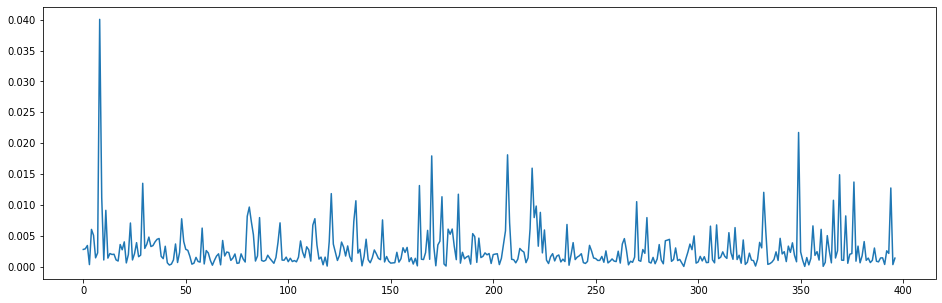

In [125]:
plt.figure(figsize=(16, 5))
plt.plot(oof[2036, :])

In [126]:
len(df[df["birds"] == "nocall"])

100

In [127]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.075

In [128]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [129]:
top5_birds

['bcnher', 'grhowl', 'gwfgoo', 'mallar3', 'warvir']

## audio_id: 57610

In [130]:
idx = valid_df[valid_df["audio_id"] == 57610].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1"])

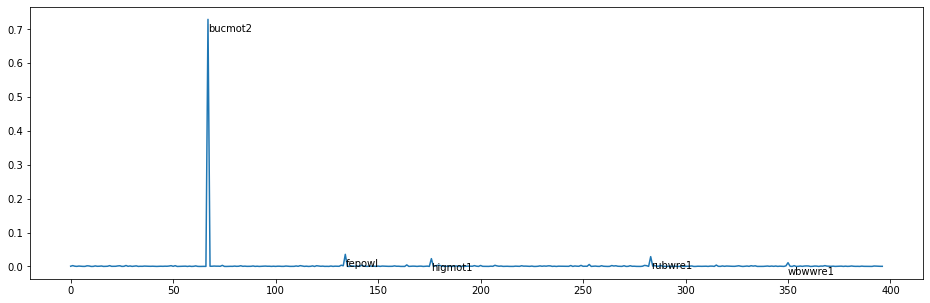

In [131]:
plot_oof(861)

In [132]:
np.max(oof[1514, :])

0.13335066481959074

In [133]:
len(df[df["birds"] == "nocall"])

93

In [134]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.18888888888888886

In [135]:
mean_ = oof[idx, :].mean(0) 

plt.figure(figsize=(16, 5))
plt.plot(mean_)

top5_bc = np.argsort(mean_)[-5:]
top5_birds = []
for bc in range(len(mean_)):
    if bc in top5_bc:
        plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
        top5_birds.append(const.INV_BIRD_CODE[bc])

In [136]:
top5_birds

['lobgna5', 'obnthr1', 'orbspa1', 'rubwre1', 'wbwwre1']

In [137]:
valid_df["div"] = np.max(oof, axis=1) / np.sort(oof, axis=1)[:, -2]

In [138]:
valid_df[valid_df["birds"] == "nocall"].sort_values(by="div").tail(100)

row_id site  audio_id  seconds   birds oof_birds post_oof_birds  \
6      11254_COR_35  COR     11254       35  nocall   wbwwre1        wbwwre1   
1229  10534_SSW_150  SSW     10534      150  nocall    bkcchi         bkcchi   
1781  42907_SSW_510  SSW     42907      510  nocall    nocall         nocall   
1279  10534_SSW_400  SSW     10534      400  nocall    nocall         nocall   
1355  20152_SSW_180  SSW     20152      180  nocall    nocall         nocall   
1341  20152_SSW_110  SSW     20152      110  nocall    nocall         nocall   
1293  10534_SSW_470  SSW     10534      470  nocall    nocall         nocall   
772   50878_COR_265  COR     50878      265  nocall    nocall         nocall   
752   50878_COR_165  COR     50878      165  nocall    nocall         nocall   
59    11254_COR_300  COR     11254      300  nocall    nocall         nocall   
430   26746_COR_355  COR     26746      355  nocall   bobfly1         nocall   
459   26746_COR_500  COR     26746      500  nocall    nocall         nocall   
47    11254_COR_240  COR     11254      240  nocall   grasal1        grasal1   
227   18003_COR_540  COR     18003      540  nocall    incdov         nocall   
811   50878_COR_460  COR     50878      460  nocall    nocall         nocall   
833   50878_COR_570  COR     50878      570  nocall    nocall         nocall   
705   44957_COR_530  COR     44957      530  nocall    nocall         nocall   
439   26746_COR_400  COR     26746      400  nocall   cregua1         nocall   
1251  10534_SSW_260  SSW     10534      260  nocall    nocall         rewbla   
1203   10534_SSW_20  SSW     10534       20  nocall    nocall         nocall   
1743  42907_SSW_320  SSW     42907      320  nocall    nocall         nocall   
1285  10534_SSW_430  SSW     10534      430  nocall    nocall         nocall   
1435  20152_SSW_580  SSW     20152      580  nocall    nocall         nocall   
1300  10534_SSW_505  SSW     10534      505  nocall    rewbla         rewbla   
416   26746_COR_285  COR     26746      285  nocall    nocall         nocall   
67    11254_COR_340  COR     11254      340  nocall    nocall         nocall   
1226  10534_SSW_135  SSW     10534      135  nocall    bkcchi         bkcchi   
1723  42907_SSW_220  SSW     42907      220  nocall   reevir1         nocall   
1752  42907_SSW_365  SSW     42907      365  nocall    nocall         nocall   
868   57610_COR_145  COR     57610      145  nocall   lesgre1         nocall   
1647  28933_SSW_440  SSW     28933      440  nocall    nocall         nocall   
797   50878_COR_390  COR     50878      390  nocall    fepowl         fepowl   
1334   20152_SSW_75  SSW     20152       75  nocall    nocall         nocall   
784   50878_COR_325  COR     50878      325  nocall   squcuc1         nocall   
1737  42907_SSW_290  SSW     42907      290  nocall    nocall         nocall   
145   18003_COR_130  COR     18003      130  nocall    nocall         nocall   
1798  42907_SSW_595  SSW     42907      595  nocall    rebwoo         nocall   
946   57610_COR_535  COR     57610      535  nocall    nocall         nocall   
1894  51010_SSW_475  SSW     51010      475  nocall    balori         nocall   
816   50878_COR_485  COR     50878      485  nocall    nocall         nocall   
1330   20152_SSW_55  SSW     20152       55  nocall    nocall         nocall   
1375  20152_SSW_280  SSW     20152      280  nocall    bcnher         nocall   
38    11254_COR_195  COR     11254      195  nocall    yebfly         yebfly   
1405  20152_SSW_430  SSW     20152      430  nocall    nocall         nocall   
175   18003_COR_280  COR     18003      280  nocall    nocall         rucwar   
335   21767_COR_480  COR     21767      480  nocall    nocall         rucwar   
1960  54955_SSW_205  SSW     54955      205  nocall    nocall         nocall   
1757  42907_SSW_390  SSW     42907      390  nocall    moudov         nocall   
51    11254_COR_260  COR     11254      260  nocall    nocall         nocall   
1335   20152_

In [139]:
plot_oof(1626)

In [140]:
train_df = pd.read_csv("../data/input/train_metadata.csv")

valid_birds = []
for birds in valid_df["birds"]:
    valid_birds += birds.split(" ")
valid_birds = list(set(valid_birds))

for bird in train_df["primary_label"].unique():
    if bird in valid_birds:
        sample_num = len(train_df[train_df["primary_label"] == bird])
        print(f"【{bird}】   sample:{sample_num}")

        bird_df = valid_df[valid_df["birds"].str.contains(bird)].reset_index(drop=True)
        bird_df["acc"] = True
        true_idx = bird_df[bird_df["oof_birds"] != bird].index
        bird_df.loc[true_idx, "acc"] = False

        print(bird_df["acc"].value_counts().sort_index())
        print("\n" * 3)

【amecro】   sample:229
False    1
Name: acc, dtype: int64




【amegfi】   sample:181
False    5
True     1
Name: acc, dtype: int64




【amerob】   sample:481
False    7
Name: acc, dtype: int64




【balori】   sample:155
False    27
True     13
Name: acc, dtype: int64




【belkin1】   sample:77
False    1
True     2
Name: acc, dtype: int64




【bkcchi】   sample:272
False    41
True     26
Name: acc, dtype: int64




【blujay】   sample:328
False    9
True     3
Name: acc, dtype: int64




【bobfly1】   sample:236
False    31
True     59
Name: acc, dtype: int64




【brnjay】   sample:66
False    4
True     3
Name: acc, dtype: int64




【bucmot2】   sample:38
False    2
True     2
Name: acc, dtype: int64




【cangoo】   sample:265
False    11
True      7
Name: acc, dtype: int64




【chswar】   sample:148
False    14
True      2
Name: acc, dtype: int64




【clcrob】   sample:195
False    3
True     1
Name: acc, dtype: int64




【comgra】   sample:128
False    3
Name: acc, dtype: int64




【comyel】   samp

## 鳥

In [141]:
birds = train_df["primary_label"].unique()

for bird in birds:
    bird_df = valid_df[valid_df["birds"].str.contains(bird)]
    
    if len(bird_df) > 0:
        print(f"TRUE LABEL: {bird}")
        print("-" * 50)
        print(bird_df["post_oof_birds"].value_counts())
        print("\n" * 3)

TRUE LABEL: amecro
--------------------------------------------------
nocall    1
Name: post_oof_birds, dtype: int64




TRUE LABEL: amegfi
--------------------------------------------------
nocall    4
gockin    1
amegfi    1
Name: post_oof_birds, dtype: int64




TRUE LABEL: amerob
--------------------------------------------------
nocall    7
Name: post_oof_birds, dtype: int64




TRUE LABEL: balori
--------------------------------------------------
nocall    18
balori    15
bkcchi     6
haiwoo     1
Name: post_oof_birds, dtype: int64




TRUE LABEL: belkin1
--------------------------------------------------
belkin1    2
rewbla     1
Name: post_oof_birds, dtype: int64




TRUE LABEL: bkcchi
--------------------------------------------------
bkcchi     27
nocall     23
reevir1    12
grycat      5
Name: post_oof_birds, dtype: int64




TRUE LABEL: blujay
--------------------------------------------------
nocall    8
blujay    4
Name: post_oof_birds, dtype: int64




TRUE LABEL: bobfly